In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args
import seaborn as sns 
import matplotlib.pyplot as plt
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
mps_device = torch.device("mps")

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./CIFAR10', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./CIFAR10', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

Files already downloaded and verified
Files already downloaded and verified


In [3]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act, dropout, use_bn, use_xavier):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        self.dropout = dropout
        self.use_bn = use_bn
        self.use_xavier = use_xavier
        
        # ====== Create Linear Layers ====== #
        self.fc1 = nn.Linear(self.in_dim, self.hid_dim)
        
        self.linears = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
            if self.use_bn:
                self.bns.append(nn.BatchNorm1d(self.hid_dim))
                
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)
        
        # ====== Create Activation Function ====== #
        if self.act == 'relu':
            self.act = nn.ReLU()
        elif self.act == 'tanh':
            self.act == nn.Tanh()
        elif self.act == 'sigmoid':
            self.act = nn.Sigmoid()
        else:
            raise ValueError('no valid activation function selected!')
        
        # ====== Create Regularization Layer ======= #
        self.dropout = nn.Dropout(self.dropout)
        if self.use_xavier:
            self.xavier_init()
          
    def forward(self, x):
        x = self.act(self.fc1(x))
        for i in range(len(self.linears)):
            x = self.act(self.linears[i](x))
            x = self.bns[i](x)
            x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def xavier_init(self):
        for linear in self.linears:
            nn.init.xavier_normal_(linear.weight)
            linear.bias.data.fill_(0.01)

In [4]:
class CNN_basic(nn.Module):
    def __init__(self):
        super(CNN_basic, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels=3, 
            out_channels=64, 
            kernel_size=3, 
            stride=1, 
            padding=1
        )
        self.conv2 = nn.Conv2d(
            in_channels=64, 
            out_channels=256, 
            kernel_size= 5, 
            stride=1, 
            padding=2
        )
        self.act = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(65536, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.act(x)
        x = self.maxpool1(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return x

In [5]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class CNN(nn.Module):
    def __init__(self, model_code, in_channels, out_dim, act, use_bn, dropout, fc_hid, fc_layers):
        super(CNN, self).__init__()
        
        if act == 'relu':
            self.act = nn.ReLU()
        elif act == 'sigmoid':
            self.act = nn.Sigmoid()
        elif act == 'tanh':
            self.act = nn.Tanh()
        elif act == 'leakyrelu':
            self.act = nn.LeakyReLU(0.1)
        else:
            raise ValueError("Not a valid activation function code")
        self.out_dim = out_dim
        self.fc_hid = fc_hid
        self.fc_layers = fc_layers
        self.dropout = dropout
        self.use_bn = use_bn
        self.fc_dropout = nn.Dropout(self.dropout)
        self.layers = self._make_layers(model_code, in_channels, self.use_bn)
        self.fc_layer = self._make_fclayers()

    def _make_layers(self, model_code, in_channels, use_bn):
        layers = []
        for x in cfg[model_code]:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]        
            else:
                layers += [
                    nn.Conv2d(
                        in_channels=in_channels, 
                        out_channels=x, 
                        kernel_size=3, 
                        stride=1, 
                        padding=1
                    ),
                    nn.ReLU()
                ]
                if use_bn:
                    layers += [nn.BatchNorm2d(x)]
                layers += [self.act]
                in_channels = x
        
        return nn.Sequential(*layers)

    def _make_fclayers(self):
        fc_layer = []
        fc_layer += [nn.Linear(512, self.fc_hid)]
        fc_layer += [self.act]
        for l in range(self.fc_layers-1):
            fc_layer += [nn.Linear(self.fc_hid, self.fc_hid)]
            fc_layer += [self.act]
            if self.use_bn:
                fc_layer += [nn.BatchNorm1d(self.fc_hid)]
        fc_layer += [nn.Linear(self.fc_hid, self.out_dim)]
        return nn.Sequential(*fc_layer)

    def forward(self, x):
        x = self.layers(x)
        x = x.view(x.size(0),-1)
        x = self.fc_layer(x)
        return x

In [6]:
def dim_check2():
    net = CNN('VGG11', 3, 10, 'relu', True, 0.5, 256, 3)
    x = torch.randn(2, 3, 32, 32)
    y = net(x)
    print(y.size())
dim_check2()

torch.Size([2, 10])


In [7]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'], 
                                              batch_size=args.train_batch_size, 
                                              shuffle=True,
                                              num_workers=2)
    net.train()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad() 

        # get the inputs
        inputs, labels = data
        inputs = inputs.to(mps_device)
        labels = labels.to(mps_device)
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [8]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=args.test_batch_size, 
                                            shuffle=False,
                                            num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.to(mps_device)
            labels = labels.to(mps_device)
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [9]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=args.test_batch_size, 
                                             shuffle=False,
                                             num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(mps_device)
            labels = labels.to(mps_device)

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc


In [10]:
def experiment(partition, args):
  
    net = CNN(model_code = args.model_code,
              in_channels = args.in_channels,
              out_dim = args.out_dim,
              act = args.act,
              use_bn = args.use_bn,
              dropout = args.dropout,
              fc_hid = args.fc_hid, 
              fc_layers = args.fc_layers
              )
    net.to(mps_device)

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(net, partition, args)    
    
    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result
    # ===================================== #

In [11]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

In [21]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "CNN1_lr_model_code"

# ====== Model ====== #
# args.model_code = 'VGG11'
args.in_channels = 3
args.out_dim = 10
args.act = 'relu'
args.fc_hid = 256
args.fc_layers = 3

# ====== Regularization ======= #
args.l2 = 0.00001
args.use_bn = True
args.dropout = 0

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
# args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 512
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'model_code'
list_var1 = [0.01, 0.001, 0.002, 0.005]
list_var2 = ['VGG11', 'VGG13', 'VGG19']


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(exp_name='CNN1_lr_model_code', in_channels=3, out_dim=10, act='relu', fc_hid=256, fc_layers=3, l2=1e-05, use_bn=True, dropout=0, optim='Adam', epoch=10, train_batch_size=512, test_batch_size=1024, lr=0.01, model_code='VGG11')
Epoch 0, Acc(train/val): 19.33/25.04, Loss(train/val) 2.14/2.03. Took 49.48 sec
Epoch 1, Acc(train/val): 38.69/43.48, Loss(train/val) 1.62/1.60. Took 49.56 sec
Epoch 2, Acc(train/val): 50.95/48.11, Loss(train/val) 1.33/inf. Took 49.12 sec
Epoch 3, Acc(train/val): 57.88/49.51, Loss(train/val) 1.16/1.43. Took 49.56 sec
Epoch 4, Acc(train/val): 64.86/60.71, Loss(train/val) 0.98/1.13. Took 49.80 sec
Epoch 5, Acc(train/val): 70.59/65.34, Loss(train/val) 0.84/1.06. Took 49.65 sec
Epoch 6, Acc(train/val): 75.08/67.16, Loss(train/val) 0.72/inf. Took 49.69 sec
Epoch 7, Acc(train/val): 78.45/69.67, Loss(train/val) 0.62/0.95. Took 49.38 sec
Epoch 8, Acc(train/val): 81.34/71.19, Loss(train/val) 0.55/inf. Took 49.36 sec
Epoch 9, Acc(train/val): 84.20/68.04, Loss(trai

<AxesSubplot: xlabel='model_code', ylabel='test_acc'>

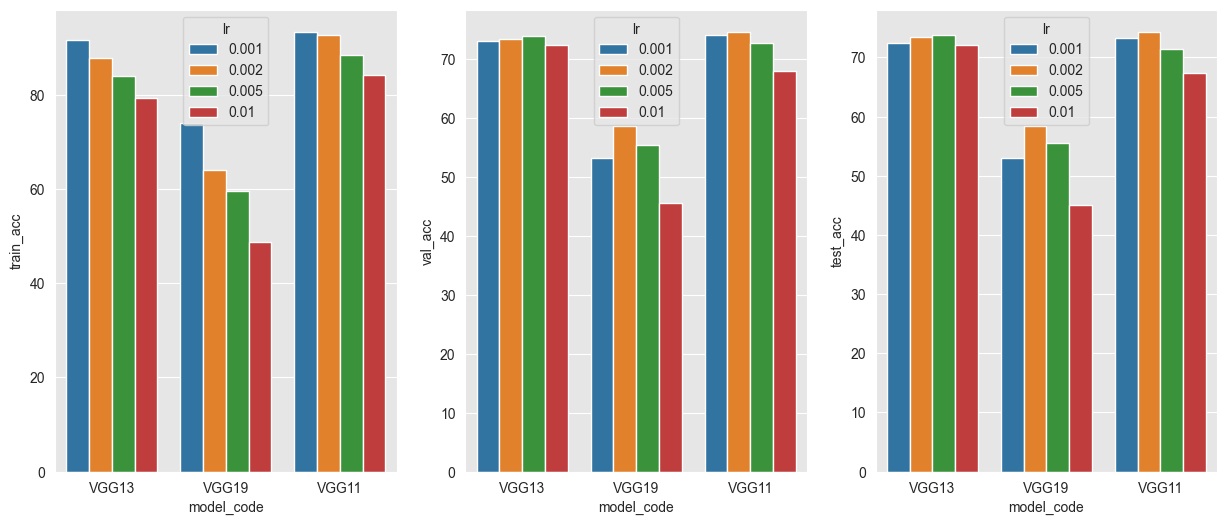

In [22]:
df = load_exp_result('CNN1_lr_model_code')

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 6)

sns.barplot(x='model_code', y='train_acc', hue='lr', data=df, ax=ax[0])
sns.barplot(x='model_code', y='val_acc', hue='lr', data=df, ax=ax[1])
sns.barplot(x='model_code', y='test_acc', hue='lr', data=df, ax=ax[2])

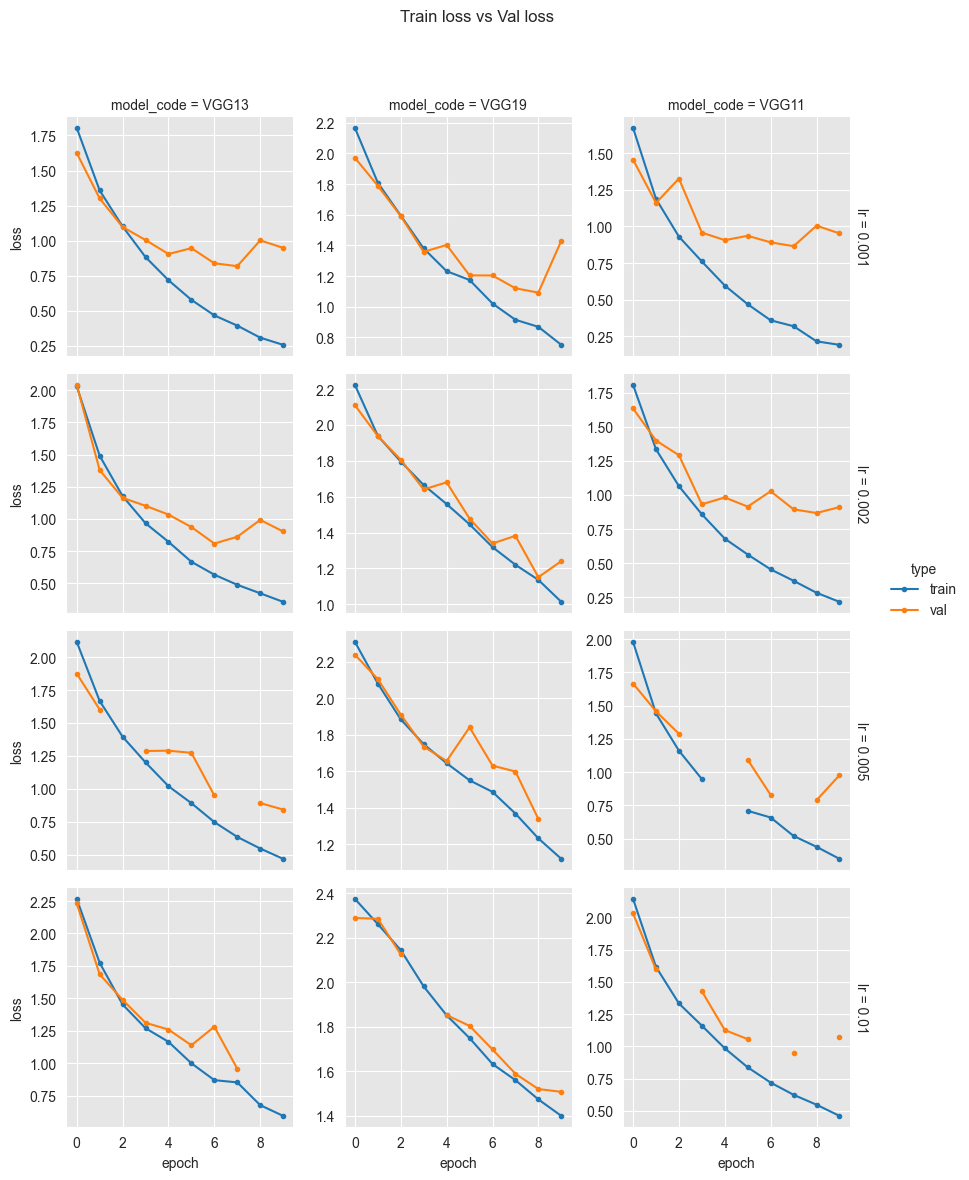

In [23]:
var1 = 'model_code'
var2 = 'lr'

list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_losses = list(row.train_losses)[0]
        val_losses = list(row.val_losses)[0]
        
        for epoch, train_loss in enumerate(train_losses):
            list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_loss in enumerate(val_losses):
            list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})
        
df_tmp = pd.DataFrame(list_data)
g = sns.FacetGrid(df_tmp, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'loss', marker='.')
g.add_legend()
g.fig.suptitle('Train loss vs Val loss')
plt.subplots_adjust(top=0.89)

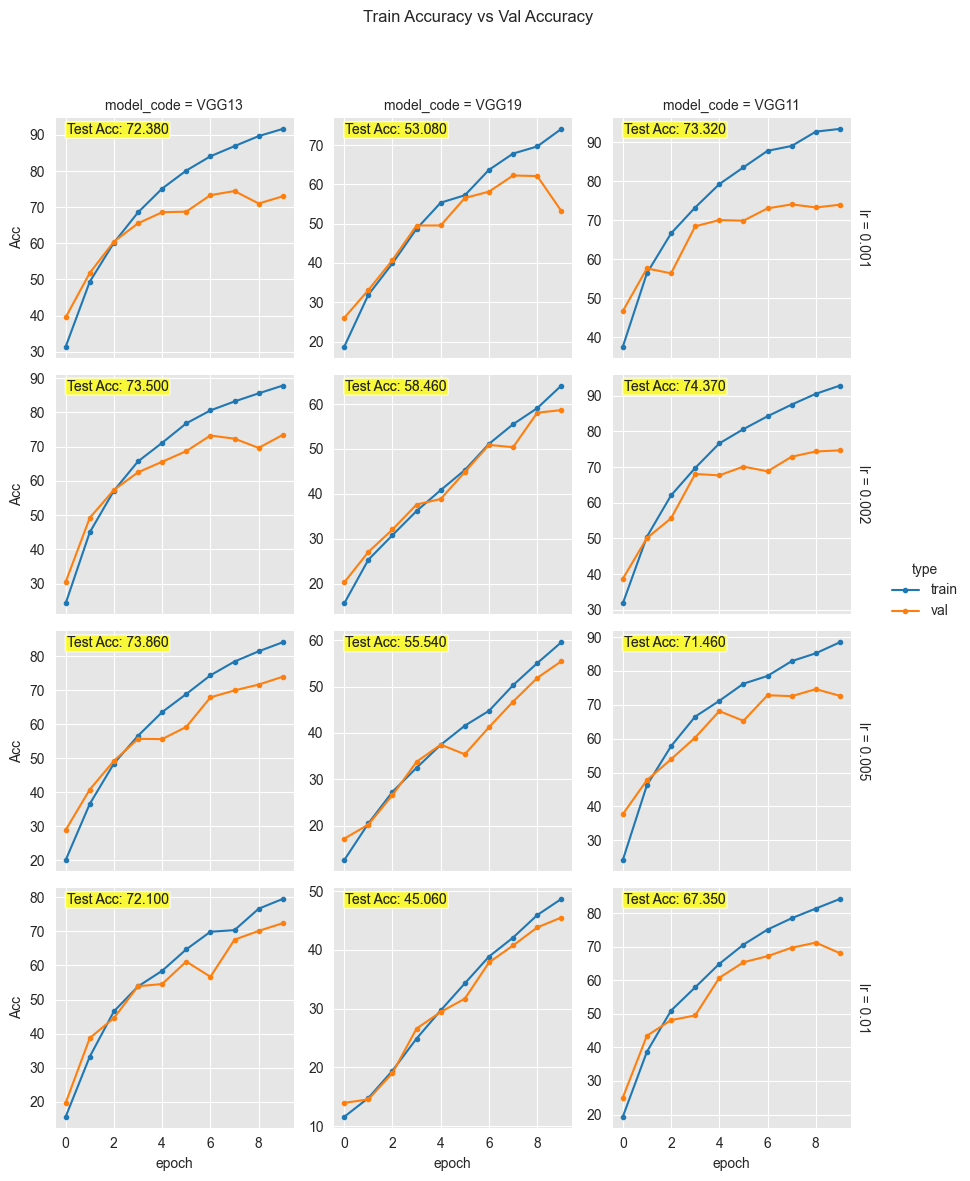

In [24]:
var1 = 'model_code'
var2 = 'lr'

list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_accs = list(row.train_accs)[0]
        val_accs = list(row.val_accs)[0]
        test_acc = list(row.test_acc)[0]
        
        for epoch, train_acc in enumerate(train_accs):
            list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_acc in enumerate(val_accs):
            list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        
df_tmp = pd.DataFrame(list_data)
g = sns.FacetGrid(df_tmp, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

def show_acc(x, y, metric, **kwargs):
    plt.scatter(x, y, alpha=0.3, s=1)
    metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
    plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

g.add_legend()
g.fig.suptitle('Train Accuracy vs Val Accuracy')



plt.subplots_adjust(top=0.89)

In [33]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "CNN1_dropout_act"

# ====== Model ====== #
args.model_code = 'VGG11'
args.in_channels = 3
args.out_dim = 10
# args.act = 'relu'
args.fc_hid = 256
args.fc_layers = 3

# ====== Regularization ======= #
args.l2 = 0.00001
args.use_bn = True
# args.dropout = 0.25

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.002
args.epoch = 15

args.train_batch_size = 512
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'act'
name_var2 = 'dropout'
list_var1 = ['relu', 'tanh', 'leakyrelu']
list_var2 = [0, 0.25 ,0.5]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(exp_name='CNN1_dropout_act', model_code='VGG11', in_channels=3, out_dim=10, fc_hid=256, fc_layers=3, l2=1e-05, use_bn=True, optim='Adam', lr=0.002, epoch=15, train_batch_size=512, test_batch_size=1024, act='relu', dropout=0)
Epoch 0, Acc(train/val): 29.57/36.90, Loss(train/val) 1.84/1.61. Took 49.05 sec
Epoch 1, Acc(train/val): 48.43/47.49, Loss(train/val) 1.37/1.50. Took 48.94 sec
Epoch 2, Acc(train/val): 60.22/58.05, Loss(train/val) 1.11/1.19. Took 48.97 sec
Epoch 3, Acc(train/val): 68.52/61.72, Loss(train/val) 0.88/1.08. Took 48.98 sec
Epoch 4, Acc(train/val): 74.46/66.73, Loss(train/val) 0.73/inf. Took 48.92 sec
Epoch 5, Acc(train/val): 79.36/70.83, Loss(train/val) 0.60/0.86. Took 49.06 sec
Epoch 6, Acc(train/val): 83.39/71.80, Loss(train/val) 0.49/0.89. Took 48.96 sec
Epoch 7, Acc(train/val): 86.23/74.22, Loss(train/val) 0.41/0.86. Took 48.91 sec
Epoch 8, Acc(train/val): 88.53/76.33, Loss(train/val) 0.34/0.78. Took 48.92 sec
Epoch 9, Acc(train/val): 91.20/75.58, Loss(tra

<AxesSubplot: xlabel='dropout', ylabel='test_acc'>

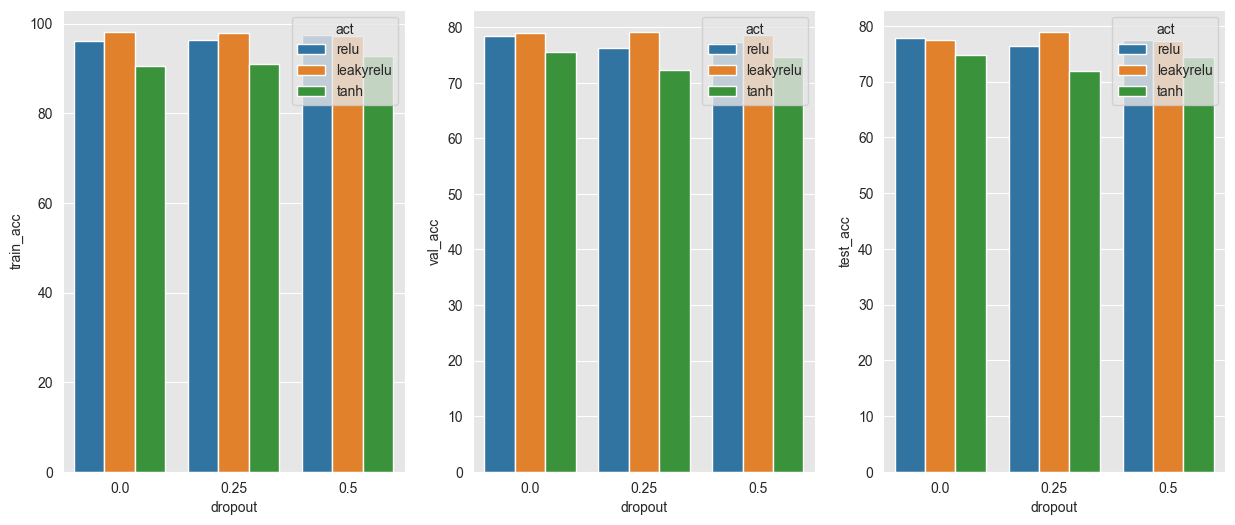

In [13]:
df = load_exp_result('CNN1_dropout_act')

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 6)

sns.barplot(x='dropout', y='train_acc', hue='act', data=df, ax=ax[0])
sns.barplot(x='dropout', y='val_acc', hue='act', data=df, ax=ax[1])
sns.barplot(x='dropout', y='test_acc', hue='act', data=df, ax=ax[2])

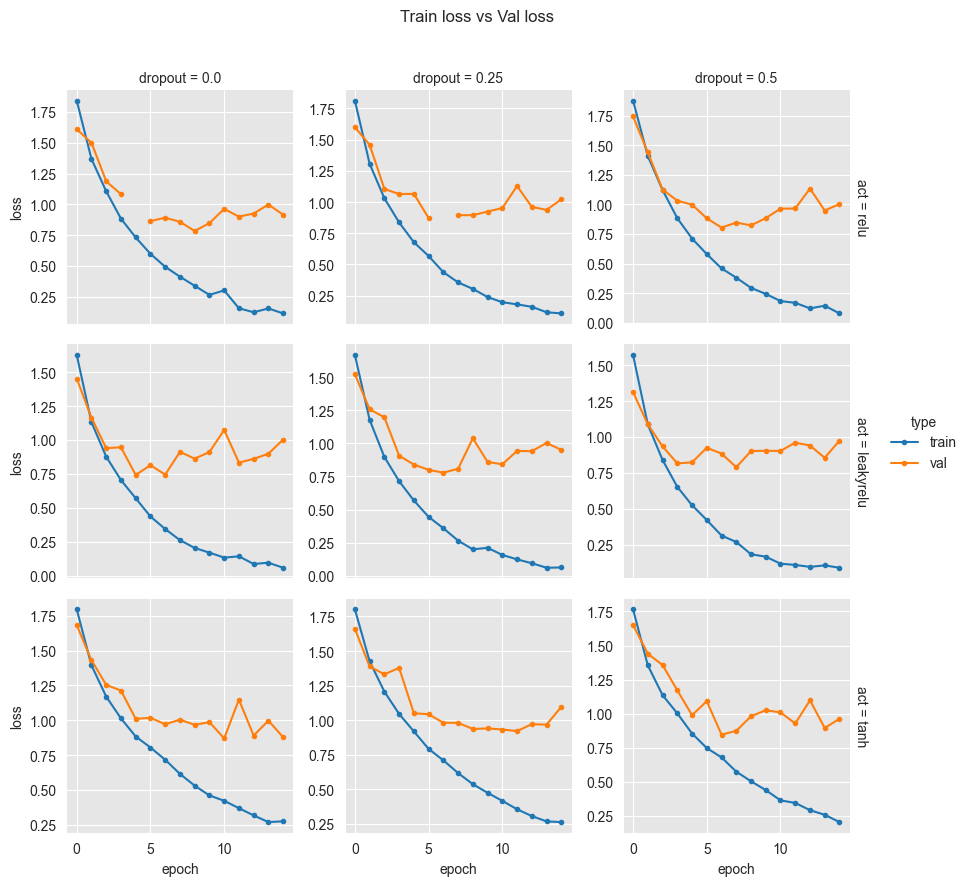

In [14]:
var1 = 'dropout'
var2 = 'act'

list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_losses = list(row.train_losses)[0]
        val_losses = list(row.val_losses)[0]
        
        for epoch, train_loss in enumerate(train_losses):
            list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_loss in enumerate(val_losses):
            list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})
        
df_tmp = pd.DataFrame(list_data)
g = sns.FacetGrid(df_tmp, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'loss', marker='.')
g.add_legend()
g.fig.suptitle('Train loss vs Val loss')
plt.subplots_adjust(top=0.89)

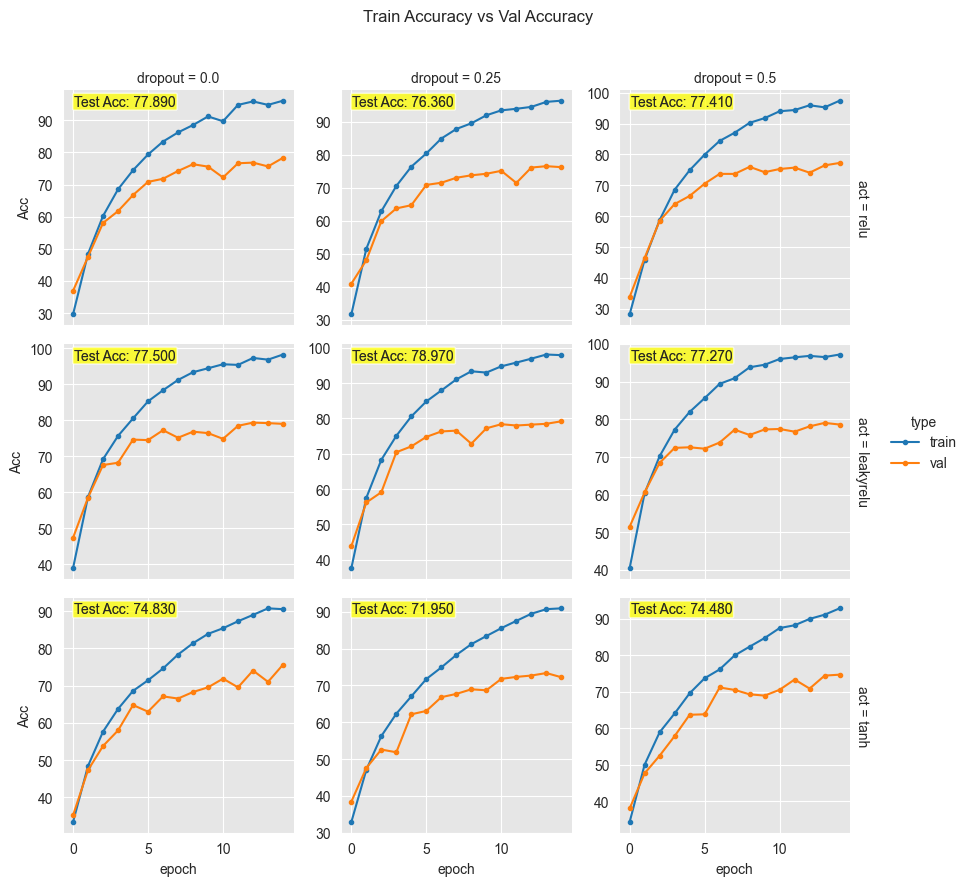

In [15]:
var1 = 'dropout'
var2 = 'act'

list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_accs = list(row.train_accs)[0]
        val_accs = list(row.val_accs)[0]
        test_acc = list(row.test_acc)[0]
        
        for epoch, train_acc in enumerate(train_accs):
            list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_acc in enumerate(val_accs):
            list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        
df_tmp = pd.DataFrame(list_data)
g = sns.FacetGrid(df_tmp, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

def show_acc(x, y, metric, **kwargs):
    plt.scatter(x, y, alpha=0.3, s=1)
    metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
    plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

g.add_legend()
g.fig.suptitle('Train Accuracy vs Val Accuracy')



plt.subplots_adjust(top=0.89)

In [17]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "CNN1_fc_layers_hid"

# ====== Model ====== #
args.model_code = 'VGG11'
args.in_channels = 3
args.out_dim = 10
args.act = 'leakyrelu'
# args.fc_hid = 256
# args.fc_layers = 3

# ====== Regularization ======= #
args.l2 = 0.00001
args.use_bn = True
args.dropout = 0.25

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.002
args.epoch = 15

args.train_batch_size = 512
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'fc_hid'
name_var2 = 'fc_layers'
list_var1 = [512,256,128]
list_var2 = [2,3,5]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(exp_name='CNN1_fc_layers_hid', model_code='VGG11', in_channels=3, out_dim=10, act='leakyrelu', l2=1e-05, use_bn=True, dropout=0.25, optim='Adam', lr=0.002, epoch=15, train_batch_size=512, test_batch_size=1024, fc_hid=512, fc_layers=2)
Epoch 0, Acc(train/val): 39.78/45.86, Loss(train/val) 1.61/1.51. Took 47.22 sec
Epoch 1, Acc(train/val): 60.37/56.65, Loss(train/val) 1.09/1.34. Took 46.63 sec
Epoch 2, Acc(train/val): 71.26/68.14, Loss(train/val) 0.81/0.92. Took 46.62 sec
Epoch 3, Acc(train/val): 78.09/72.71, Loss(train/val) 0.63/0.78. Took 46.61 sec
Epoch 4, Acc(train/val): 83.01/72.55, Loss(train/val) 0.49/0.85. Took 46.63 sec
Epoch 5, Acc(train/val): 87.35/75.74, Loss(train/val) 0.37/0.81. Took 46.70 sec
Epoch 6, Acc(train/val): 89.36/75.20, Loss(train/val) 0.31/0.79. Took 46.65 sec
Epoch 7, Acc(train/val): 92.39/75.16, Loss(train/val) 0.23/0.93. Took 46.71 sec
Epoch 8, Acc(train/val): 94.57/76.43, Loss(train/val) 0.16/0.86. Took 46.66 sec
Epoch 9, Acc(train/val): 94.77/76.7

<AxesSubplot: xlabel='fc_hid', ylabel='test_acc'>

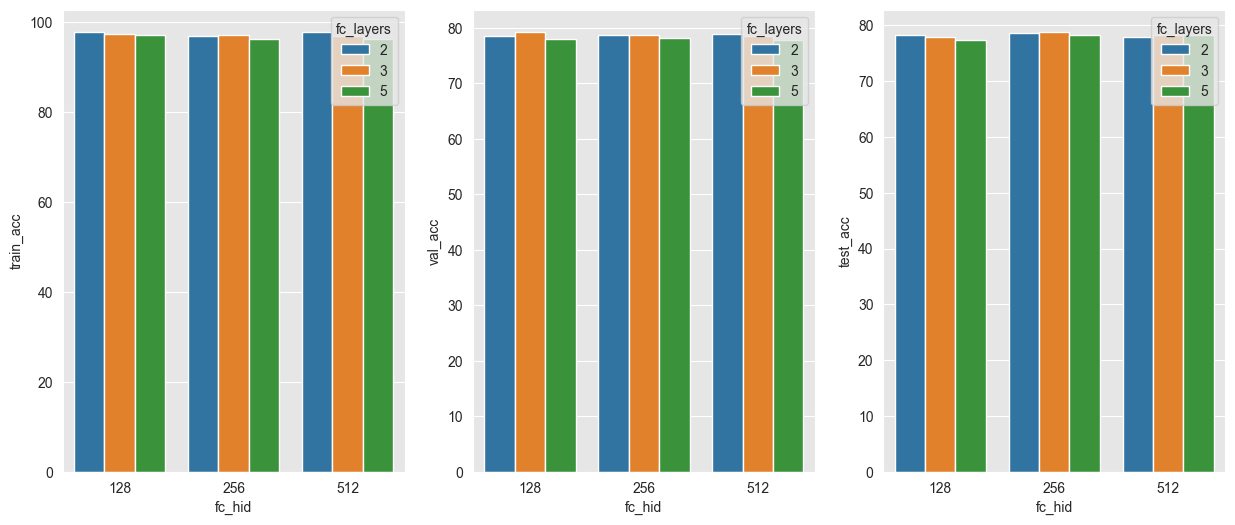

In [19]:
df = load_exp_result('CNN1_fc_layers_hid')

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 6)

sns.barplot(x='fc_hid', y='train_acc', hue='fc_layers', data=df, ax=ax[0])
sns.barplot(x='fc_hid', y='val_acc', hue='fc_layers', data=df, ax=ax[1])
sns.barplot(x='fc_hid', y='test_acc', hue='fc_layers', data=df, ax=ax[2])

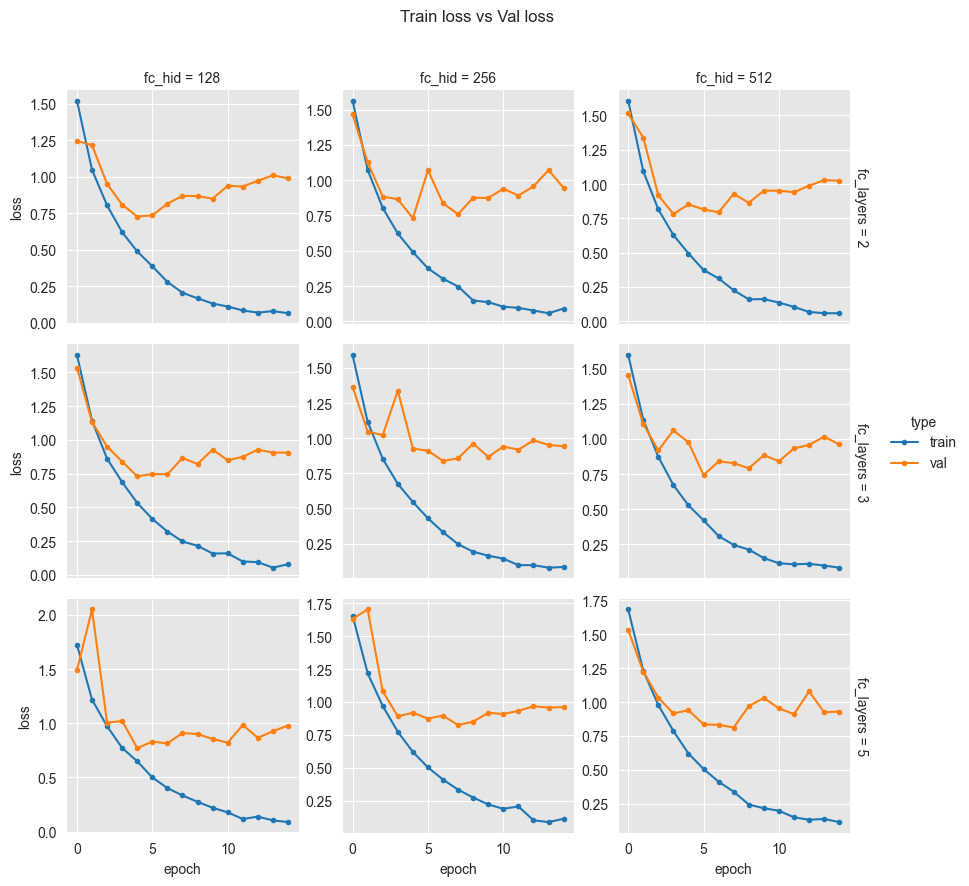

In [20]:
var1 = 'fc_hid'
var2 = 'fc_layers'

list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_losses = list(row.train_losses)[0]
        val_losses = list(row.val_losses)[0]
        
        for epoch, train_loss in enumerate(train_losses):
            list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_loss in enumerate(val_losses):
            list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})
        
df_tmp = pd.DataFrame(list_data)
g = sns.FacetGrid(df_tmp, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'loss', marker='.')
g.add_legend()
g.fig.suptitle('Train loss vs Val loss')
plt.subplots_adjust(top=0.89)

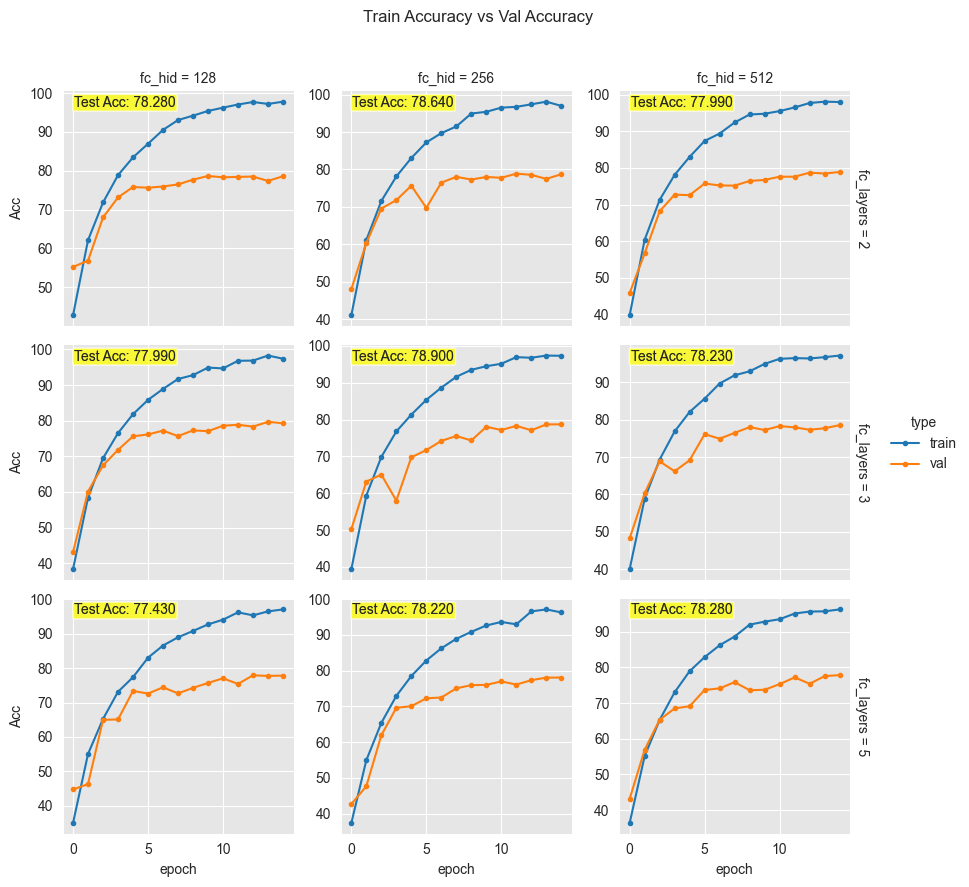

In [21]:
var1 = 'fc_hid'
var2 = 'fc_layers'

list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_accs = list(row.train_accs)[0]
        val_accs = list(row.val_accs)[0]
        test_acc = list(row.test_acc)[0]
        
        for epoch, train_acc in enumerate(train_accs):
            list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_acc in enumerate(val_accs):
            list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        
df_tmp = pd.DataFrame(list_data)
g = sns.FacetGrid(df_tmp, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

def show_acc(x, y, metric, **kwargs):
    plt.scatter(x, y, alpha=0.3, s=1)
    metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
    plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

g.add_legend()
g.fig.suptitle('Train Accuracy vs Val Accuracy')



plt.subplots_adjust(top=0.89)

In [19]:
# epoch 과 batch size결정 
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "CNN1_early_stopping"

# ====== Model ====== #
args.model_code = 'VGG11'
args.in_channels = 3
args.out_dim = 10
args.act = 'leakyrelu'
args.fc_hid = 256
args.fc_layers = 3

# ====== Regularization ======= #
args.l2 = 0.00001
args.use_bn = True
args.dropout = 0.25

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.002
args.epoch = 30

args.train_batch_size = 128
args.test_batch_size = 1024

In [20]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [21]:
def experiment_early_stop(partition, args):
  
    net = CNN(model_code = args.model_code,
              in_channels = args.in_channels,
              out_dim = args.out_dim,
              act = args.act,
              use_bn = args.use_bn,
              dropout = args.dropout,
              fc_hid = args.fc_hid, 
              fc_layers = args.fc_layers
              )
    net.to(mps_device)

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    patience = 20
    early_stopping = EarlyStopping(patience = patience, verbose = True)
    # ===================================== #
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
        early_stopping(val_loss, net)

        if early_stopping.early_stop:
            print("Early stopping")
            break


    test_acc = test(net, partition, args)    
    
    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result
    # ===================================== #

In [22]:
setting, result = experiment_early_stop(partition, deepcopy(args))
save_exp_result(setting, result)

Epoch 0, Acc(train/val): 40.69/52.07, Loss(train/val) 1.57/1.34. Took 57.33 sec
Validation loss decreased (inf --> 1.340601).  Saving model ...
Epoch 1, Acc(train/val): 62.73/65.38, Loss(train/val) 1.05/1.01. Took 55.77 sec
Validation loss decreased (1.340601 --> 1.010478).  Saving model ...
Epoch 2, Acc(train/val): 72.62/72.60, Loss(train/val) 0.80/0.79. Took 56.18 sec
Validation loss decreased (1.010478 --> 0.790940).  Saving model ...
Epoch 3, Acc(train/val): 78.61/76.36, Loss(train/val) 0.63/0.72. Took 55.60 sec
Validation loss decreased (0.790940 --> 0.717056).  Saving model ...
Epoch 4, Acc(train/val): 82.75/77.83, Loss(train/val) 0.52/0.67. Took 55.59 sec
Validation loss decreased (0.717056 --> 0.671261).  Saving model ...
Epoch 5, Acc(train/val): 86.07/78.17, Loss(train/val) 0.41/0.67. Took 55.91 sec
Validation loss decreased (0.671261 --> 0.665987).  Saving model ...
Epoch 6, Acc(train/val): 89.24/79.17, Loss(train/val) 0.32/0.66. Took 55.59 sec
Validation loss decreased (0.66

In [37]:
df = pd.DataFrame.from_dict(result)
df

,train_losses,val_losses,train_accs,val_accs,train_acc,val_acc,test_acc,exp_name,model_code,in_channels,out_dim,act,fc_hid,fc_layers,l2,use_bn,dropout,optim,lr,train_batch_size
0,1.572563,1.340601,40.6900,52.07,98.2,81.05,80.11,CNN1_early_stopping,VGG11,3,10,leakyrelu,256,3,0.00001,True,0.25,Adam,0.002,128
1,1.051647,1.010478,62.7350,65.38,98.2,81.05,80.11,CNN1_early_stopping,VGG11,3,10,leakyrelu,256,3,0.00001,True,0.25,Adam,0.002,128
2,0.800633,0.790940,72.6225,72.60,98.2,81.05,80.11,CNN1_early_stopping,VGG11,3,10,leakyrelu,256,3,0.00001,True,0.25,Adam,0.002,128
3,0.632837,0.717056,78.6125,76.36,98.2,81.05,80.11,CNN1_early_stopping,VGG11,3,10,leakyrelu,256,3,0.00001,True,0.25,Adam,0.002,128
4,0.516747,0.671261,82.7450,77.83,98.2,81.05,80.11,CNN1_early_stopping,VGG11,3,10,leakyrelu,256,3,0.00001,True,0.25,Adam,0.002,128
5,0.408318,0.665987,86.0675,78.17,98.2,81.05,80.11,CNN1_early_stopping,VGG11,3,10,leakyrelu,256,3,0.00001,True,0.25,Adam,0.002,128
6,0.319933,0.663633,89.2425,79.17,98.2,81.05,80.11,CNN1_early_stopping,VGG11,3,10,leakyrelu,256,3,0.00001,True,0.25,Adam,0.002,128
7,0.255536,0.670827,91.5025,79.71,98.2,81.05,80.11,CNN1_early_stopping,VGG11,3,10,leakyrelu,256,3,0.00001,True,0.25,Adam,0.002,128
8,0.204911,0.727242,93.2125,79.22,98.2,81.05,80.11,CNN1_early_stopping,VGG11,3,10,leakyrelu,256,3,0.00001,True,0.25,Adam,0.002,128
9,0.177544,0.808107,94.1100,78.38,98.2,81.05,80.11,CNN1_early_stopping,VGG11,3,10,leakyrelu,256,3,0.00001,True,0.25,Adam,0.002,128


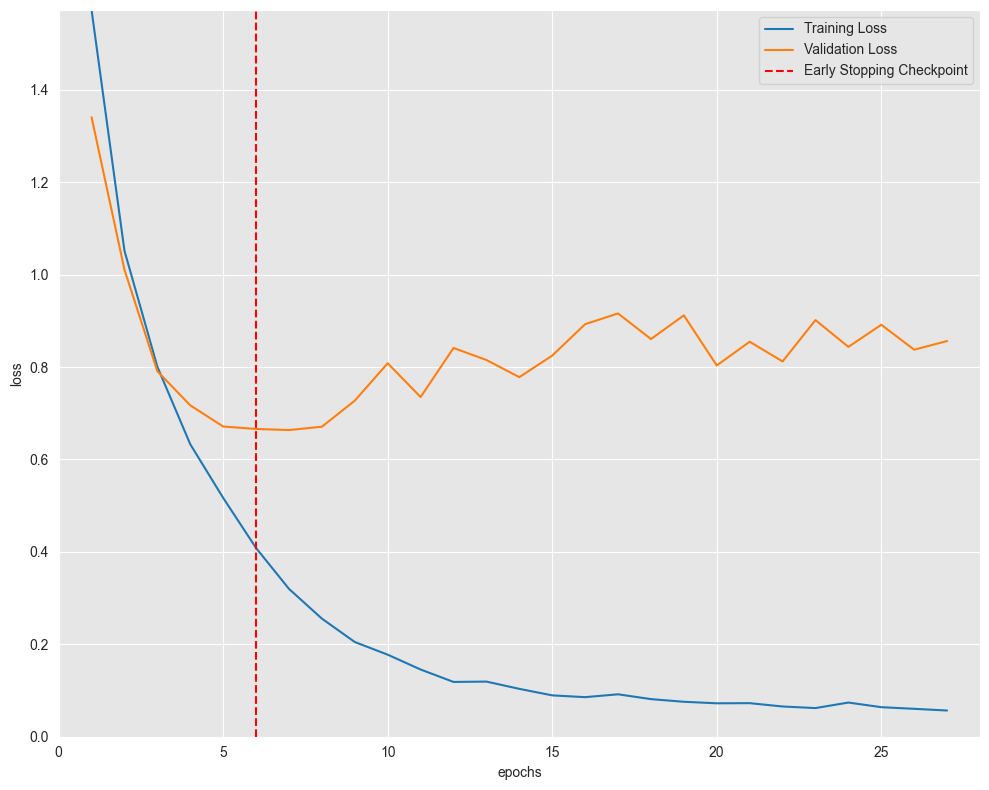

In [41]:
# 훈련이 진행되는 과정에 따라 loss를 시각화

train_loss = df['train_losses'].values
valid_loss = df['val_losses'].values

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# validation loss의 최저값 지점을 찾기
minposs = np.argmin(valid_loss)
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, train_loss.max()) # 일정한 scale
plt.xlim(0, len(train_loss)+1) # 일정한 scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()